### Recurrent neural networks

RNN은 미래를 예측하기 위해 고안된 신경망이다.

시계열 데이터를 분석해서 예측하기 위한 것으로 임의 길이를 가진 시퀀스를 다룰 수 있다.

### 순환 뉴런

지금까지는 활성화 신호가 입력층에서 출력층 한 방향으로만 흐르는 피드포워드 신경망에 초점을 맞추었지만

순환 신경망은 뒤쪽으로 순환하는 연결도 있다는 점이 다르다.

입력을 받아 출력을 만들고 자신에게도 출력을 보내는 뉴런을 생각해 보자.

각 타임 스텝 $t$ (프레임)마다 이 순환 뉴런은 $x_t$와 이전 타임 스텝의 출력인 $y_{t-1}$을 입력으로 받는다.

첫 번째 타임스텝에서는 이전 출력이 없으므로 0으로 설정.

각 순환 뉴런은 두 벌의 가중치를 지닌다.

하나는 입력 $x_t$를 위한 것이고, 다른 하나는 이전 타임 스텝의 출력 $y_{t-1}$를 위한 것이다.


In [31]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [32]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [33]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [34]:
y_train

array([[-0.35489398],
       [ 0.11629631],
       [-0.35395944],
       ...,
       [ 0.04946356],
       [-0.26231018],
       [ 0.60062087]], dtype=float32)

In [35]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

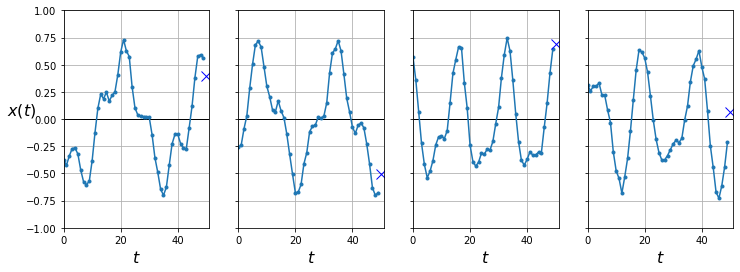

In [36]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(12, 4))
for col in range(4):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

In [39]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

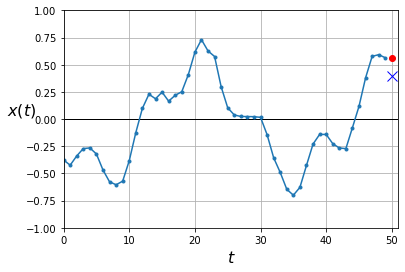

In [40]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [9]:
X_train[:1]

array([[[ 0.4596948 ],
        [ 0.31486678],
        [ 0.12497123],
        [-0.1039134 ],
        [-0.33817387],
        [-0.53167135],
        [-0.65472883],
        [-0.6680997 ],
        [-0.6068115 ],
        [-0.50168324],
        [-0.27951923],
        [-0.15070675],
        [ 0.01001816],
        [ 0.11860766],
        [ 0.09566415],
        [ 0.1479297 ],
        [ 0.16850619],
        [ 0.19524719],
        [ 0.22094081],
        [ 0.38448656],
        [ 0.4021102 ],
        [ 0.5566975 ],
        [ 0.55000687],
        [ 0.47437248],
        [ 0.29733396],
        [ 0.13306592],
        [-0.1292547 ],
        [-0.36367297],
        [-0.49515054],
        [-0.65279794],
        [-0.6665792 ],
        [-0.5604573 ],
        [-0.50344354],
        [-0.28775147],
        [-0.12684062],
        [-0.0095053 ],
        [ 0.12024356],
        [ 0.18013756],
        [ 0.1559989 ],
        [ 0.1756968 ],
        [ 0.217454  ],
        [ 0.30272725],
        [ 0.38143268],
        [ 0

In [10]:
keras.layers.SimpleRNN(1, input_shape=[None, 1])(X_train[:1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.52922136]], dtype=float32)>

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [42]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [43]:
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 10ms/step - loss: 0.1554 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0409 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0277 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0208 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0174 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0138 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0128 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0117 - val_loss: 0.011

In [44]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0109


0.010881561785936356

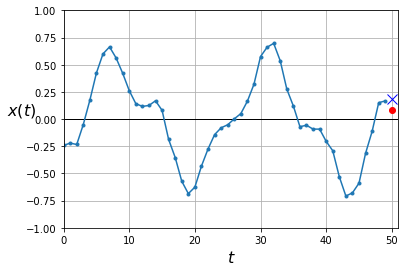

In [51]:
y_pred = model.predict(X_valid)
plot_series(X_valid[4, :, 0], y_valid[4, 0], y_pred[4, 0])
plt.show()

#### 심층 RNN

In [63]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

In [60]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_11 (SimpleRNN)    (None, None, 20)          440       
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, 20)                820       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
 96/219 [============>.................] - ETA: 1s - loss: 0.0897

KeyboardInterrupt: 

In [53]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0026


0.002623623237013817

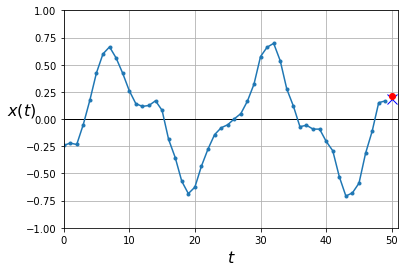

In [58]:
y_pred = model.predict(X_valid)
plot_series(X_valid[4, :, 0], y_valid[4, 0], y_pred[4, 0])
plt.show()

#### 여러 스텝에 대한 예측

첫번째 방법으로 이미 훈련한 모델을 사용하여 다음 값을 예측한 다음 이 값을 입력으로 추가하여 다시 다음 값을 예측하는 방법

더 미래에 대한 예측일수록 오차가 누적될 수 있다.

In [64]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [65]:
Y_pred.shape

(1, 10, 1)

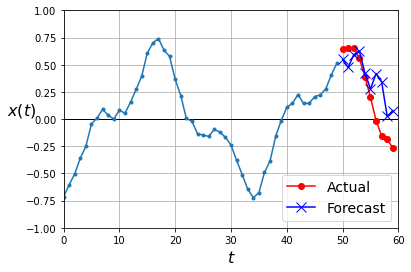

In [66]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

두번째 방법으로 RNN을 훈련하여 다음 값 10개를 한 번에 예측하는 것이다.

시퀀스-투-벡터 모델을 사용하지만 1개가 아니라 값 10개를 출력한다.

먼저 target을 다음 10개의 값이 담긴 벡터로 바꾸어야 한다.

In [67]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [79]:
Y_train.shape

(7000, 50, 10)

1개가 아닌 10개의 유닛을 가진 출력층이 필요하다.

In [69]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

In [70]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_17 (SimpleRNN)    (None, None, 20)          440       
_________________________________________________________________
simple_rnn_18 (SimpleRNN)    (None, 20)                820       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 18ms/step - loss: 0.1216 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0294 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0198 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0162 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0144 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0127 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0118 - val_lo

In [72]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

이 모델은 잘 작동하는 편이다.

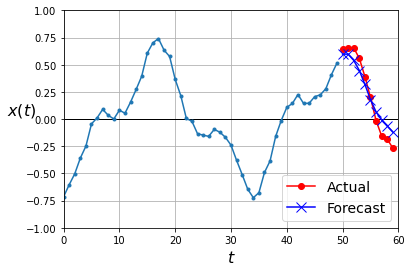

In [73]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

하지만 개선의 여지도 있다.

마지막 타임 스텝에서만 다음 10개의 값을 예측하도록 훈련하는 대신, 모든 타임 스텝에서 다음 10개의 값을 예측하도록 훈련할 수 있다.

시퀀스-투-시퀀스 RNN을 훈련하는 것이다.

구체적으로 보자면 타임 스텝 0에서 타임 스텝 1에서 10까지의 예측이 담긴 벡터를 출력할 것이다.

그 다음 타임 스텝 1에서 이 모델은 타임 스텝 2에서 11까지 예측할 것이다.

In [74]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [75]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

이를 위해서는 모든 순환 층에 ```return_sequences=True```로 설정해야 한다.

그 다음 모든 타임 스텝에서 출력을 Dense 층에 적용할 수 있도록 ```TimeDistributed``` 층을 사용한다.

이 층은 각 타임 스텝을 별개의 샘플처럼 다루도록 입력의 크기를 바꾸어 효과적으로 수행한다.

즉 입력을 (배치크기, 타임 스텝 수, 입력 차원)에서 (배치크기 * 타임 스텝 수, 입력차원)의 크기로 바꾼다.

In [80]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [81]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_21 (SimpleRNN)    (None, None, 20)          440       
_________________________________________________________________
simple_rnn_22 (SimpleRNN)    (None, None, 20)          820       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 10)          210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [82]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 17ms/step - loss: 0.0705 - last_time_step_mse: 0.0621 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0413 - last_time_step_mse: 0.0301 - val_loss: 0.0368 - val_last_time_step_mse: 0.0267
Epoch 3/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0340 - last_time_step_mse: 0.0229 - val_loss: 0.0296 - val_last_time_step_mse: 0.0173
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0298 - last_time_step_mse: 0.0187 - val_loss: 0.0279 - val_last_time_step_mse: 0.0160
Epoch 5/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0280 - last_time_step_mse: 0.0167 - val_loss: 0.0255 - val_last_time_step_mse: 0.0132
Epoch 6/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0257 - last_time_step_mse: 0.0133 - val_loss: 0.0220 - val_last_time_step_mse: 0.0085
Epoch 7/20
219/219 [==

In [83]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

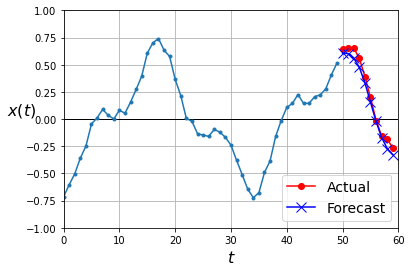

In [84]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()